1. Import Packages

In [7]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble  import  RandomForestClassifier
from  sklearn.metrics  import  roc_auc_score as AUC
from  sklearn.metrics import  mean_absolute_error
from sklearn.decomposition import  PCA
from sklearn.preprocessing import  LabelEncoder,LabelBinarizer
# from sklearn.cross_validation import  cross_val_score
from  sklearn.model_selection import  cross_val_score
from scipy import  stats
import  seaborn as sns
from copy import  deepcopy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
import xgboost as xgb
import pandas as pd
import  numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,make_scorer
from  sklearn.preprocessing import  StandardScaler
from  scipy.sparse import  csr_matrix,hstack
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from  xgboost import  XGBRFRegressor

2. Load Data

In [14]:
test = pd.read_csv('test.csv')

In [12]:
train = pd.read_csv('train.csv')

3. Explore Dataset

In [27]:
print(train.shape)
print(train.head())

(188318, 132)
   id cat1 cat2 cat3 cat4  ...    cont11    cont12    cont13    cont14     loss
0   1    A    B    A    B  ...  0.569745  0.594646  0.822493  0.714843  2213.18
1   2    A    B    A    A  ...  0.338312  0.366307  0.611431  0.304496  1283.60
2   5    A    B    A    A  ...  0.381398  0.373424  0.195709  0.774425  3005.09
3  10    B    B    A    B  ...  0.327915  0.321570  0.605077  0.602642   939.85
4  11    A    B    A    B  ...  0.204687  0.202213  0.246011  0.432606  2763.85

[5 rows x 132 columns]


In [17]:
print(test.shape)
print(test.head())

(125546, 131)
   id cat1 cat2 cat3 cat4  ...   cont10    cont11    cont12    cont13    cont14
0   4    A    B    A    A  ...  0.38016  0.377724  0.369858  0.704052  0.392562
1   6    A    B    A    B  ...  0.60401  0.689039  0.675759  0.453468  0.208045
2   9    A    B    A    B  ...  0.30529  0.245410  0.241676  0.258586  0.297232
3  12    A    A    A    A  ...  0.31480  0.348867  0.341872  0.592264  0.555955
4  15    B    A    A    A  ...  0.50556  0.359572  0.352251  0.301535  0.825823

[5 rows x 131 columns]


In [18]:
#check datasets
print('First 20 columns:',list(train.columns[:20]))
print('Last 20 columns:',list(train.columns[-20:]))

train.describe() #datasets have been preprossed since all the cont has been reduced to [0,1]. Means of cont are around 0.5. we have got the feature datasets.

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [20]:
#check missing values
pd.isnull(train).values.any()

False

In [19]:
#check division of categorical and continus features.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [15]:
cat_features=list(train.select_dtypes(include=['object']).columns)
print("Categorical:{} features".format(len(cat_features)))


cont_features=[cont for cont in  list(train.select_dtypes(include=['float64','int64']).columns)
               if cont not in ['loss','id']]
print("Continuous:{} features".format(len(cont_features)))

id_col=list(train.select_dtypes(include=['int64']).columns)
print("A column of int64:{}".format(id_col))

Categorical:116 features
Continuous:14 features
A column of int64:['id']


In [16]:
#check distinct values in a feature
cat_uniques=[]
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))

data={'cat_name':cat_features,'unique_values':cat_uniques}
uniq_values_in_categories=pd.DataFrame.from_dict(data)
print(uniq_values_in_categories.head())

  cat_name  unique_values
0     cat1              2
1     cat2              2
2     cat3              2
3     cat4              2
4     cat5              2


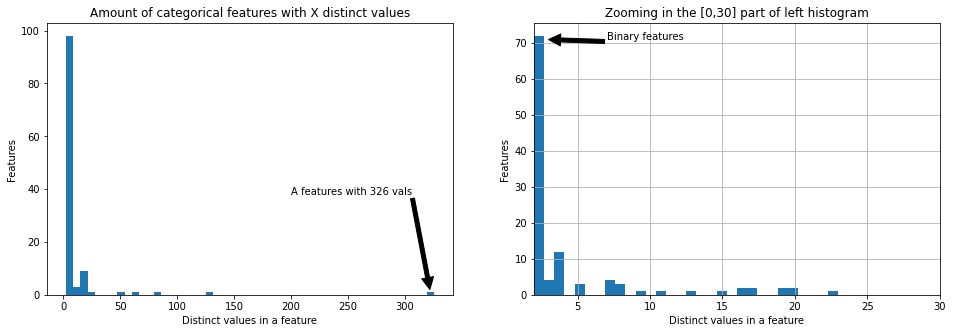

In [25]:
#plot
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.unique_values,bins=50)
ax1.set_title("Amount of categorical features with X distinct values")
ax1.set_xlabel("Distinct values in a feature")
ax1.set_ylabel("Features")
ax1.annotate('A features with 326 vals',xy=(322,2),xytext=(200,38),
             arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title("Zooming in the [0,30] part of left histogram")
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values<=30].unique_values,bins=30)
ax2.annotate('Binary features',xy=(3,71),xytext=(7,71),arrowprops=dict(facecolor='black'))
fig.show()
plt.show()

No handles with labels found to put in legend.


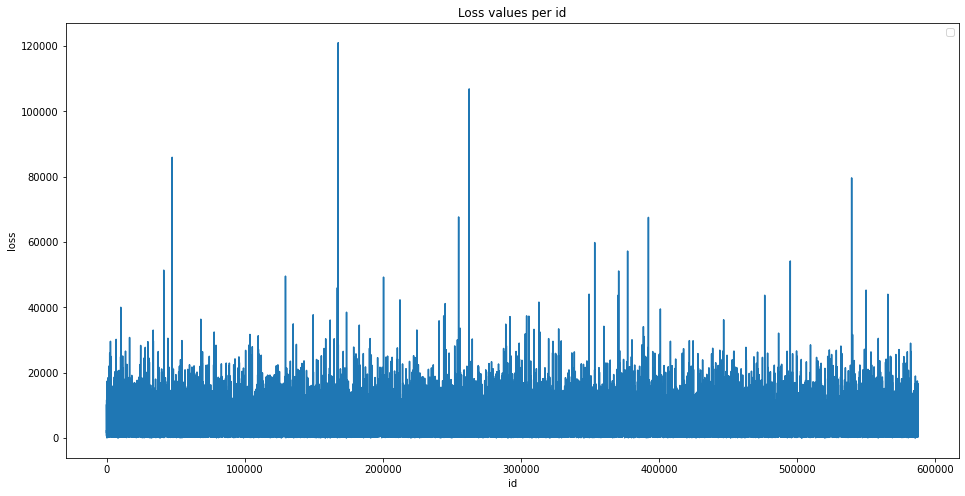

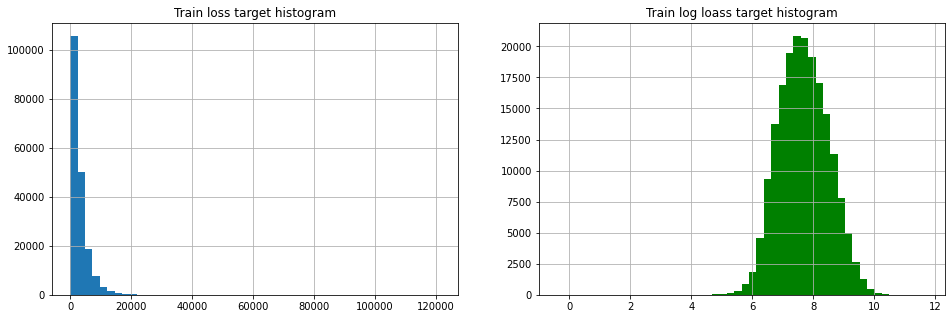

In [30]:
#target: loss value
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

In [32]:
#skewness
stats.mstats.skew(train['loss']).data

array(3.79492815)

In [35]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

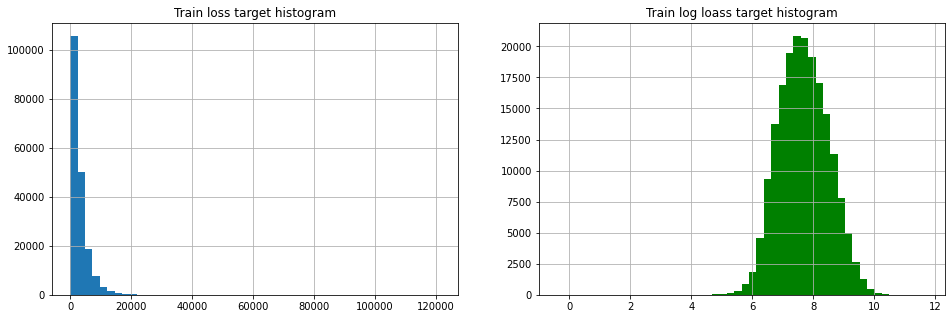

In [33]:
#log transform
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'],bins=50)
ax1.set_title('Train loss target histogram')
ax1.grid(True)

ax2.hist(np.log(train['loss']),bins=50,color='g')
ax2.set_title('Train log loass target histogram')
ax2.grid(True)
plt.show()

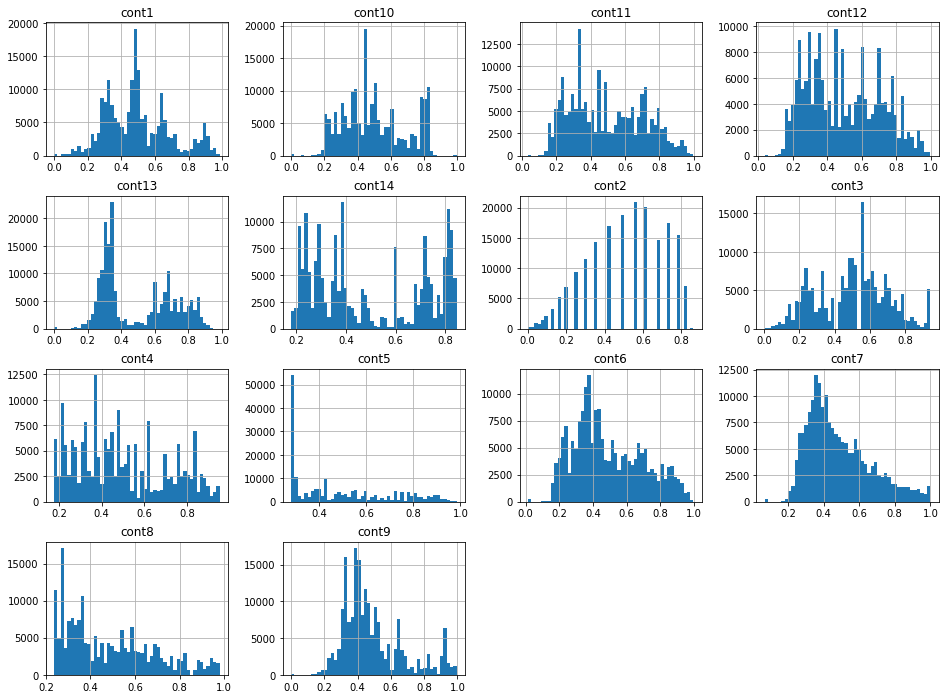

In [31]:
#plot cont features
train[cont_features].hist(bins=50,figsize=(16,12))
plt.show()

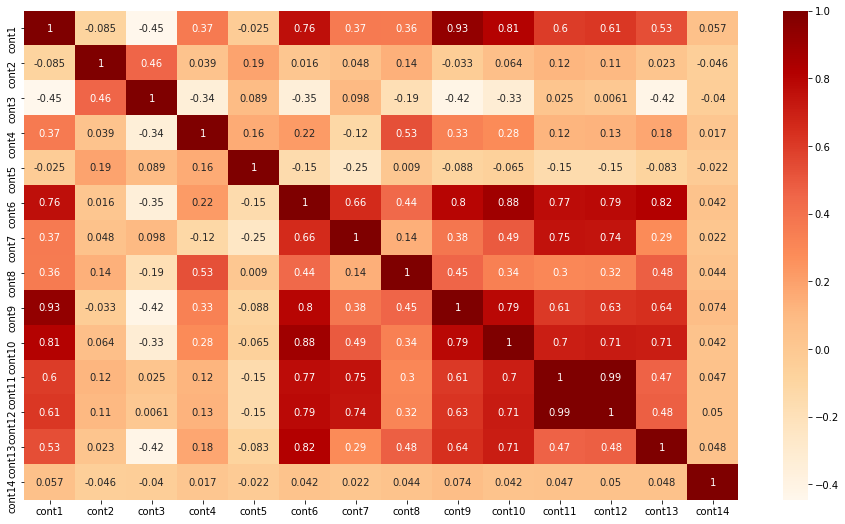

In [36]:
#correlations among features
plt.subplots(figsize=(16,9))
correlation_mat=train[cont_features].corr()
sns.heatmap(correlation_mat,annot=True, cmap="OrRd")
plt.show()

4. Model 

In [17]:
#log transform
train['log_loss']=np.log(train['loss'])

features=[x for x in train.columns if x not in ['id','loss','log_loss']]
cat_features=[x for x in  train.select_dtypes(include=['object']).columns
              if x not in ['id','loss','log_loss']]  #72: 2 unique values，88: four uniqle values
num_features=[x for x in train.select_dtypes(exclude=['object']).columns
              if x not in ['id','loss','log_loss']]

print("Categorical features:",len(cat_features))
print("Numerical features:",len(num_features))

ntrain=train.shape[0]
train_x=train[features]
train_y=train['log_loss']

Categorical features: 116
Numerical features: 14


In [18]:
#encode categorical features
for c in range(len(cat_features)):
    train_x[cat_features[c]]=train_x[cat_features[c]].astype('category').cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#map
category_dict={col: {cat: n for n, cat in enumerate(train[col].astype('category').cat.categories )}
                     for col in cat_features}

In [20]:
#Simple XGBoost Model
def xg_eval_mae(yhat,dtrain):
    y=dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

In [21]:
dtrain=xgb.DMatrix(train_x,train['log_loss'])

In [22]:
#first model 50 trees
xgb_params={
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'silent':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}

CV score: 1220.138631
CPU times: user 2min 2s, sys: 763 ms, total: 2min 3s
Wall time: 1min 3s


<Figure size 432x288 with 0 Axes>

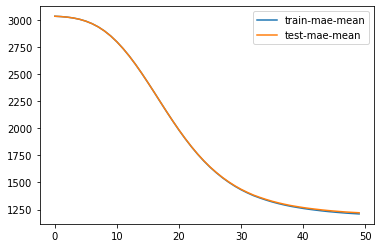

In [23]:
#evaluation: xgb.cv
%%time

bst_cvl=xgb.cv(xgb_params,dtrain,num_boost_round=50,nfold=3,seed=0
               ,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10) 

print('CV score:',bst_cvl.iloc[-1,:]['test-mae-mean'])

plt.figure()
bst_cvl[['train-mae-mean','test-mae-mean']].plot()

In [46]:
#100 trees
%%time
bst_cv2=xgb.cv(xgb_params,dtrain,num_boost_round=100,
               nfold=3,seed=0,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print('CV score:',bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1172.4588626666666
CPU times: user 4min 5s, sys: 195 ms, total: 4min 5s
Wall time: 2min 5s


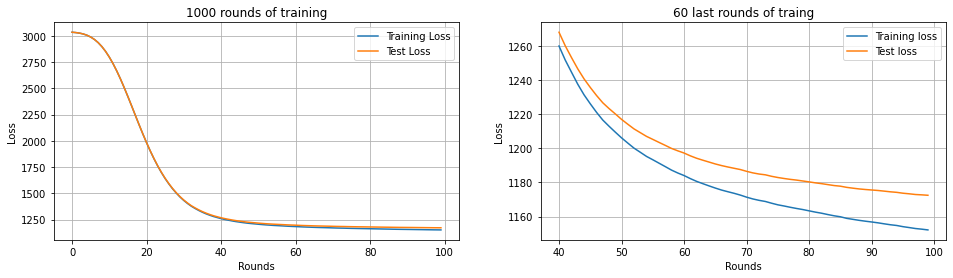

In [47]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('1000 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean','test-mae-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title('60 last rounds of traing')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean','test-mae-mean']]) 
ax2.legend(['Training loss','Test loss'])
plt.show()

5. Grid Search

In [24]:
class XGBoostRegressor(object):
    def __init__(self,**kwargs):
        self.params=kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round=self.params['num_boost_round']
        self.params.update({'silent':1,'objective':'reg:linear','seed':0})
    def fit(self,x_train,y_train):
        dtrain=xgb.DMatrix(x_train,y_train)
        self.bst=xgb.train(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                           feval=xg_eval_mae,maximize=False)
    def predict(self,x_pred):
        dpred=xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    def kfold(self,x_train,y_train,nfold=5):
        dtrain=xgb.DMatrix(x_train,y_train)
        cv_rounds=xgb.cv(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                         nfold=nfold,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
        return  cv_rounds.iloc[-1,:]
    def plot_feature_importances(self):
        feat_imp=pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importance')
        plt.ylabel('Feature Importance Score')
    def get_params(self,deep=True):
        return self.params
    def set_params(self,**params):
        self.params.update((params))
        return self


def mae_score(y_true,y_pred):
    return  mean_absolute_error(np.exp(y_true),np.exp(y_pred))

mae_scorer=make_scorer(mae_score,greater_is_better=False)

In [25]:
#base model
bst=XGBoostRegressor(eta=0.1,colsample_bytree=0.5,subsample=0.5,max_depth=5,min_child_weight=3,num_boost_round=50)
bst.kfold(train_x,train_y,nfold=5)

train-mae-mean     1208.575903
train-mae-std         2.065637
train-rmse-mean       0.558723
train-rmse-std        0.000888
test-mae-mean      1217.096240
test-mae-std         11.171228
test-rmse-mean        0.562311
test-rmse-std         0.002872
Name: 49, dtype: float64

In [26]:
#grid search: max_depth & min_child_weight
xgb_param_grid={'max_depth':list((range(4,9))),'min_child_weight':list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [55]:
%%time
grid=GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,colsample_bytree=0.5,subsample=0.5),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

CPU times: user 1h 11min 45s, sys: 3.81 s, total: 1h 11min 49s
Wall time: 36min 44s


In [56]:
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params']
grid.best_params_,grid.best_score_

({'max_depth': 8, 'min_child_weight': 6}, -1186.5915677901896)

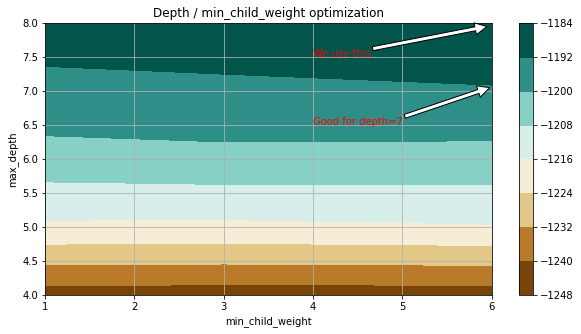

In [57]:
def convert_grid_scores():
    _params=[]
    _params_pair=[]
    params_temp = grid.cv_results_['params']
    for i in range(0,len(params_temp)):
        a=list(params_temp[i].values())[0]
        b=list(params_temp[i].values())[1]
        _params_pair.append([a,b])
        _params.append(b)
    _params_mae=grid.cv_results_['mean_test_score']
    params=np.array(_params)
    grid_res=np.column_stack((params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

_,scores=convert_grid_scores()
scores=scores.reshape(5,3) #array

plt.figure(figsize=(10,5))
cp=plt.contourf(xgb_param_grid['min_child_weight'],xgb_param_grid['max_depth'],scores,cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this',xy=(5.95,7.95),xytext=(4,7.5),arrowprops=dict(facecolor='white'),color='red')
plt.annotate('Good for depth=7',xy=(5.98,7.05),xytext=(4,6.5),arrowprops=dict(facecolor='white'),color='red')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

In [58]:
#grid search: gamma
xgb_param_grid={'gamma':[0.1 * i for i in range(0,5)]}
grid=GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,max_depth=8,min_child_weight=6,colsample_bytree=0.5,
                                   subsample=0.5),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

pd1=pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2=pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_

({'gamma': 0.2}, -1186.3330534146753)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'annote'


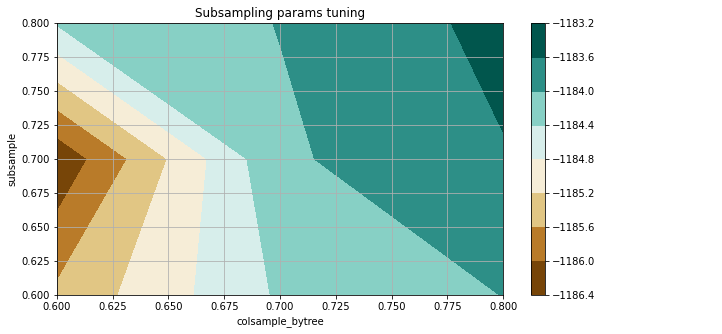

In [59]:
#Grid Search: subsample & colsample_bytree

xgb_param_grid={'subsample':[0.1 * i for i in range(6,9)],
                'colsample_bytree':[0.1 * i for i in range(6,9)]}
grid=GridSearchCV(XGBoostRegressor(eta=0.1,ganma=0.2,num_boost_round=50,max_depth=8,min_child_weight=6),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

pd1=pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2=pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_

_,scores=convert_grid_scores()
scores=scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp=plt.contourf(xgb_param_grid['subsample'],xgb_param_grid['colsample_bytree'],scores,cmap='BrBG',annote=True)
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum',xy=(0.895,0.6),xytext=(0.8,0.695),arrowprops=dict(facecolor='black'))
plt.xlabel('colsample_bytree')
plt.ylabel('subsample')
plt.grid(True)
plt.show()

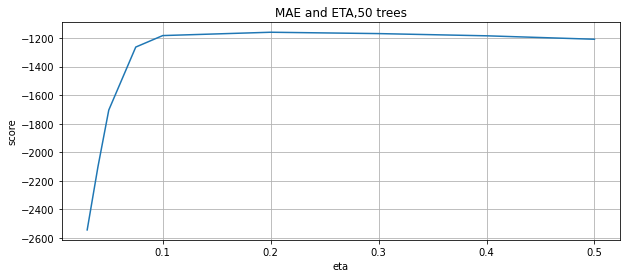

In [60]:
#reduce eta and increase num_boost_round
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid=GridSearchCV(XGBoostRegressor(num_boost_round=50,gamma=0.2,max_depth=8,min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

pd1=pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2=pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_

a=pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
plt.figure(figsize=(10,4))
plt.title('MAE and ETA,50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(a.eta,a.mean_test_score)
plt.grid(True)
plt.show()

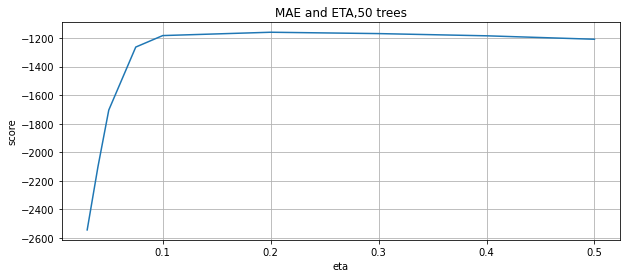

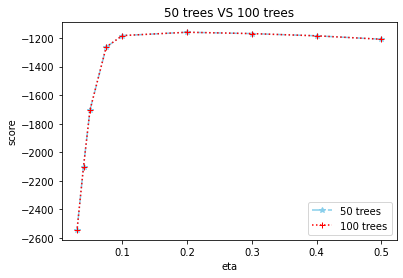

In [61]:
#eta grid when num_boost_round = 100
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid=GridSearchCV(XGBoostRegressor(num_boost_round=100,gamma=0.2,max_depth=8,min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)



pd1=pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2=pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_
# ({'eta': 0.1}, -1152.0884962236082)

In [ ]:
b=pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
plt.figure(figsize=(10,4))
plt.title('MAE and ETA,50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(a.eta,a.mean_test_score)
plt.grid(True)
plt.show()

plt.title('50 trees VS 100 trees')
plt.plot(a.eta, a.mean_test_score, color='skyblue', label='50 trees', ls='-.', marker='*')
plt.plot(b.eta, a.mean_test_score, color='red', label='100 trees', ls=':', marker='+')
plt.legend()
plt.xlabel('eta')
plt.ylabel('score')
plt.show()

In [63]:
#eta grid when num_boost_round = 200
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid=GridSearchCV(XGBoostRegressor(num_boost_round=200,gamma=0.2,max_depth=8,min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)


pd1=pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2=pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_

({'eta': 0.075}, -1146.5787174753498)

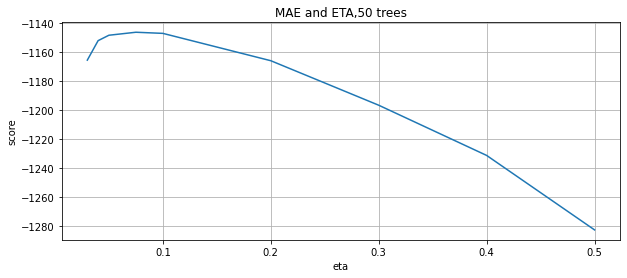

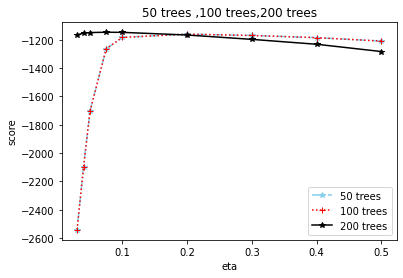

In [64]:
c=pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
plt.figure(figsize=(10,4))
plt.title('MAE and ETA,50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(c.eta,c.mean_test_score)
plt.grid(True)
plt.show()



plt.title('50 trees ,100 trees,200 trees')
plt.plot(a.eta, a.mean_test_score, color='skyblue', label='50 trees', ls='-.', marker='*')
plt.plot(b.eta, a.mean_test_score, color='red', label='100 trees', ls=':', marker='+')
plt.plot(c.eta, c.mean_test_score, color='black', label='200 trees', marker='*')

plt.legend()
plt.xlabel('eta')
plt.ylabel('score')
plt.show()

In [27]:
#final: eta = 0.075 num_boost_round = 200
xgb_param_grid={'eta':[0.075]}
grid=GridSearchCV(XGBoostRegressor(num_boost_round=200,gamma=0.2,max_depth=8,min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                  param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)


pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params']
rslt_pd=pd.merge(pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score'],pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params'],
                 left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_


({'eta': 0.075}, -1146.5787174753498)

In [28]:
#use model:
for col in cat_features:
    test[col]=test[col].map(category_dict.get(col))

In [29]:
#convert loss to original value
temp=grid.predict(test[features])
predict_outmodel=np.round(np.exp(temp),4)

6. Save Model

In [30]:
#1.save model
from sklearn.externals import joblib
joblib.dump(grid,'grid.model')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['grid.model']

In [33]:
# 2. write json
import json
jsObj = json.dumps(category_dict)
fileObject = open('jsonFile.json', 'w')
fileObject.write(jsObj)
fileObject.close()

In [35]:
#3. save features
import json
jsObj = json.dumps(features)
fileObject = open('features.json', 'w')
fileObject.write(jsObj)
fileObject.close()

In [37]:
#4. save cat_feature
import json
jsObj = json.dumps(cat_features)
fileObject = open('cat_features.json', 'w')
fileObject.write(jsObj)
fileObject.close()

7. Load Model

In [39]:
def xg_eval_mae(yhat,dtrain):
    y=dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

class XGBoostRegressor(object):
    def __init__(self,**kwargs):
        self.params=kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round=self.params['num_boost_round']
        self.params.update({'silent':1,'objective':'reg:linear','seed':0})
    def fit(self,x_train,y_train):
        dtrain=xgb.DMatrix(x_train,y_train)
        self.bst=xgb.train(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                           feval=xg_eval_mae,maximize=False)
    def predict(self,x_pred):
        dpred=xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    def kfold(self,x_train,y_train,nfold=5):
        dtrain=xgb.DMatrix(x_train,y_train)
        cv_rounds=xgb.cv(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                         nfold=nfold,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
        return  cv_rounds.iloc[-1,:]
    def plot_feature_importances(self):
        feat_imp=pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importance')
        plt.ylabel('Feature Importance Score')
    def get_params(self,deep=True):
        return self.params
    def set_params(self,**params):
        self.params.update((params))
        return self


def mae_score(y_true,y_pred):
    return  mean_absolute_error(np.exp(y_true),np.exp(y_pred))

mae_scorer=make_scorer(mae_score,greater_is_better=False)


In [40]:
#load model
import  pandas as pd
from sklearn.externals import joblib
grid=joblib.load('grid.model')

In [41]:
#load dict
import json
file = open('jsonFile.json', 'r')
js = file.read()
dic = json.loads(js)
file.close()

In [42]:
#load features
import json
file = open('features.json', 'r')
js = file.read()
features = json.loads(js)
file.close()

In [43]:
#load cat_features
import json
file = open('cat_features.json', 'r')
js = file.read()
list_features = json.loads(js)
file.close()

In [44]:
test = pd.read_csv('test.csv')
for col in list_features:
    test[col]=test[col].map(dic.get(col))

temp=grid.predict(test[features])

In [45]:
temp

array([7.3063416, 7.6374493, 9.159702 , ..., 7.842589 , 6.9370203,
       7.945583 ], dtype=float32)